In [739]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [740]:
device=torch.device("cuda")

import numpy as np
train_st=np.load('./processed_data/station/train.npy')
train_lab=np.load('./processed_data/labels/train_labels.npy')
test_st=np.load('./processed_data/station/test.npy')
test_lab=np.load('./processed_data/labels/test_labels.npy')
no2_train_sat=np.load('./processed_data/no2_train.npy')
o3_test_sat=np.load('./processed_data/o3_test.npy')
no2_test_sat=np.load('./processed_data/no2_test.npy')
o3_train_sat=np.load('./processed_data/o3_train.npy')



In [741]:
print(no2_train_sat.shape,o3_train_sat.shape)

satellite=np.stack((no2_train_sat,o3_train_sat),axis=0)
# satellite=o3_train_sat
satellite=torch.tensor(satellite,dtype=torch.float32).to(device)
satellite_hourly=torch.repeat_interleave(satellite,24,dim=1)
# satellite_hourly=torch.repeat_interleave(satellite,24,dim=0)
satellite_hourly.shape

(730, 9, 10) (730, 9, 10)


torch.Size([2, 17520, 9, 10])

In [742]:
test_satellite=np.stack((no2_test_sat,o3_test_sat),axis=0)
# test_satellite=o3_test_sat
test_satellite=torch.tensor(test_satellite,dtype=torch.float32).to(device)
test_satellite_hourly=torch.repeat_interleave(test_satellite,24,dim=1)
# test_satellite_hourly=torch.repeat_interleave(test_satellite,24,dim=0)
test_satellite_hourly.shape

torch.Size([2, 8784, 9, 10])

In [743]:
import numpy as np

def log_standardize(x, mean=None, std=None):
    """
    Apply log1p transform, then standardize.
    
    Parameters
    ----------
    x : array-like
        Input values (e.g., ozone concentrations).
    mean : float, optional
        Mean from training set. If None, computed from x.
    std : float, optional
        Std from training set. If None, computed from x.
    
    Returns
    -------
    x_scaled : np.ndarray
        Log-transformed + standardized values.
    mean : float
        Mean used for scaling (store this for test data).
    std : float
        Std used for scaling (store this for test data).
    """
    x_log = np.log1p(x)
    
    if mean is None:
        mean = x_log.mean()
    if std is None:
        std = x_log.std()
        
    
    x_scaled = (x_log - mean) / std
    return x_scaled, mean, std


In [744]:
labels_scaled,train_mean,train_std=log_standardize(train_lab)
testlabels_scaled,_,_=log_standardize(test_lab,train_mean,train_std)

In [745]:
print(train_st.shape)
train_st=np.concat([train_st,labels_scaled],axis=1)
print(train_st.shape)

(17520, 16)
(17520, 18)


In [746]:
test_st=np.concat([test_st,testlabels_scaled],axis=1)
print(test_st.shape)

(8784, 18)


In [747]:
station=torch.tensor(train_st,dtype=torch.float32).to(device)
print(station.shape)

labels=torch.tensor(labels_scaled,dtype=torch.float32).to(device)
labels=labels[6:]
print(labels.shape)

satellite_hourly_seq=satellite_hourly.unfold(dimension=1,size=6,step=1).permute(1,4,0,2,3)
station_seq=station.unfold(dimension=0,size=6,step=1)
satellite_hourly_seq=satellite_hourly_seq[:-1,...]
station_seq=station_seq[:-1,...]
station_seq=station_seq.permute(0,2,1)
print(satellite_hourly_seq.shape)
print(station_seq.shape)


torch.Size([17520, 18])
torch.Size([17514, 2])
torch.Size([17514, 6, 2, 9, 10])
torch.Size([17514, 6, 18])


In [748]:
test_station=torch.tensor(test_st,dtype=torch.float32).to(device)
print(test_station.shape)

test_labels=torch.tensor(testlabels_scaled,dtype=torch.float32).to(device)
test_labels=test_labels[6:]
print(test_labels.shape)

test_satellite_hourly_seq=test_satellite_hourly.unfold(dimension=1,size=6,step=1).permute(1,4,0,2,3)
test_station_seq=test_station.unfold(dimension=0,size=6,step=1)
test_satellite_hourly_seq=test_satellite_hourly_seq[:-1,...]
test_station_seq=test_station_seq[:-1,...]
test_station_seq=test_station_seq.permute(0,2,1)
print(test_satellite_hourly_seq.shape)
print(test_station_seq.shape)


torch.Size([8784, 18])
torch.Size([8778, 2])
torch.Size([8778, 6, 2, 9, 10])
torch.Size([8778, 6, 18])


In [749]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNEncoder(nn.Module):
    """Encodes a single-channel satellite grid into a compact 16-dim feature vector."""
    def __init__(self, in_channels=1, output_size=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, output_size, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)              # Downsample early
        x = F.relu(self.conv2(x))
        x = self.pool(x)              # Downsample again
        x = torch.mean(x, dim=[2, 3])  # [B, output_size]
        return torch.tanh(x)

class BahdanauAttention(nn.Module):
    
    def __init__(self, hidden_size, attn_dim=64):
        super().__init__()
        # Projects hidden state into attention space
        self.W = nn.Linear(hidden_size, attn_dim)
        # Scoring vector u0
        self.v = nn.Linear(attn_dim, 1, bias=False)
        # Optional bias term d_j is already absorbed in nn.Linear

    def forward(self, lstm_out):
        """
        lstm_out: [batch, seq_len, hidden_size]
        """
        # 1. Project hidden states with tanh nonlinearity
        energy = torch.tanh(self.W(lstm_out))           # [batch, seq_len, attn_dim]

        # 2. Compute scores for each timestep
        scores = self.v(energy).squeeze(-1)             # [batch, seq_len]

        # 3. Normalize to get attention weights
        weights = torch.softmax(scores, dim=1)          # [batch, seq_len]

        # 4. Weighted sum of hidden states
        context = torch.bmm(weights.unsqueeze(1), lstm_out)  # [batch, 1, hidden_size]

        return context.squeeze(1), weights 
    
class MLPProj(nn.Module):
    def __init__(self, in_dim=18, hidden=128, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.GELU(),
            nn.LayerNorm(hidden),
            nn.Dropout(0.1),
            nn.Linear(hidden, out_dim),
            nn.GELU(),
            nn.LayerNorm(out_dim),
        )

    def forward(self, x):
        return self.net(x)

class CNNFeatureAttention(nn.Module):
    """Attention over CNN-encoded features per timestep."""
    def __init__(self, feature_dim, attn_dim=64):
        super().__init__()
        self.W = nn.Linear(feature_dim, attn_dim)
        self.v = nn.Linear(attn_dim, feature_dim, bias=False)

    def forward(self, cnn_x):
        """
        cnn_x: [batch, seq_len, feature_dim]
        """
        # Project features
        energy = torch.tanh(self.W(cnn_x))        # [batch, seq_len, attn_dim]

        # Scores per feature
        scores = self.v(energy)                   # [batch, seq_len, feature_dim]

        # Normalize across features
        weights = torch.softmax(scores, dim=-1)   # [batch, seq_len, feature_dim]

        # Weighted cnn embedding
        reweighted = cnn_x * weights              # [batch, seq_len, feature_dim]

        return reweighted, weights

class GatedProj(nn.Module):
    def __init__(self, in_dim=18, out_dim=64, r=8):
        super().__init__()
        self.proj = MLPProj(in_dim, out_dim)
        self.gate = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        emb = self.proj(x)            # [B, out_dim]
        g = self.gate(x)              # [B, out_dim] in (0,1)
        return emb * g

class FusionModel(nn.Module):
    """Fuses CNN-encoded satellite data with station features, then forecasts pollutants."""
    def __init__(
        self,
        sat_channels=2,
        station_features=18,
        cnn_out=64,
        out_dim=32,
        lstm_hidden=64,
        lstm_layers=1,
        dropout=0.15
    ):
        super().__init__()

        # Choose encoder
        self.cnn_o3 = CNNEncoder(in_channels=1,output_size=out_dim)
        self.cnn_no2 = CNNEncoder(in_channels=1,output_size=out_dim)
        # self.cnn = LinearEncoder(in_channels=sat_channels, output_size=cnn_out)

        self.feature_attn=CNNFeatureAttention(feature_dim=64)

        self.attn_o3 = BahdanauAttention(hidden_size=2*lstm_hidden)
        self.attn_no2=BahdanauAttention(hidden_size=2*lstm_hidden)

        lstm_input_size = cnn_out+64
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.station_proj=nn.Linear(station_features,64)
        # Heads for O3 and NO2
        self.head_O3 = nn.Linear(2*lstm_hidden, 1)
        self.head_NO2 = nn.Linear(2*lstm_hidden, 1)

    def forward(self, sat_x, station_x):
        """
        sat_x: [batch, seq_len, channels, H, W]
        station_x: [batch, seq_len, station_features]
        """
        batch_size, seq_len, _, _, _ = sat_x.shape

        # Encode each time step
        cnn_embeds = []
        for t in range(seq_len):
            o3_grid = sat_x[:, t, 1].unsqueeze(1)   # [batch, 1, 9, 10]
            no2_grid = sat_x[:, t, 0].unsqueeze(1)  # [batch, 1, 9, 10]

            o3_feat = self.cnn_o3(o3_grid)     # [batch, 32]
            no2_feat = self.cnn_no2(no2_grid)  # [batch, 32]

            fused = torch.cat([o3_feat, no2_feat], dim=-1)  # [batch, 64]
            cnn_embeds.append(fused)

        
        cnn_embeds = torch.stack(cnn_embeds, dim=1)  # [batch, seq_len, cnn_out]
        # cnn_context, station_weights = self.feature_attn(cnn_embeds)
        # Fuse with station features
        station_x=self.station_proj(station_x)
        station_x,st_wt=self.feature_attn(station_x)

        lstm_in = torch.cat((cnn_embeds, station_x), dim=-1)

        # Temporal modeling
        lstm_out, (hn, cn) = self.lstm(lstm_in)
        final_state = hn[-1]  # [batch, lstm_hidden]
        context_no2,_=self.attn_no2(lstm_out)
        context_o3,_=self.attn_o3(lstm_out)
        # # Predict O3 and NO2
        pred_o3 = self.head_O3(context_o3)
        pred_no2 = self.head_NO2(context_no2)

        return torch.cat((pred_no2,pred_o3), dim=1),_  # [batch, 2]



In [750]:

class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        if not (0 < quantile < 1):
            raise ValueError("Quantile must be between 0 and 1.")
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        errors = y_true - y_pred
        loss = torch.where(errors >= 0, self.quantile * errors, (self.quantile - 1) * errors)
        return torch.mean(loss)


In [751]:
import torch.optim as optim

sat_data=satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=station_seq #[17508, 16, 12]
labels=labels# ([17508, 2])


print(sat_data.shape,station_data.shape,labels.shape)

# Create Dataset and DataLoader
dataset = TensorDataset(sat_data, station_data, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

# ======================        lstm_in = torch.cat((cnn_embeds, station_context), dim=2)

# Init model + optimizer
# ======================
model = FusionModel(
    sat_channels=2,
    station_features=18,   # match your station features
    cnn_out=32,
    out_dim=16,
    lstm_hidden=256,
    lstm_layers=1,
    dropout=0.15
).to(device)

criterion = nn.L1Loss()       # regression forecasting
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# ====================
# Training Loop
# ====================
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for sat_batch, station_batch, y_batch in dataloader:
        sat_batch = sat_batch.to(device, dtype=torch.float32)
        station_batch = station_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds,wt_st= model(sat_batch, station_batch)  # [batch, 2]

        loss = criterion(preds, y_batch)
        # weights = torch.tensor([1.0, 2.0], device=preds.device)  # ozone heavier
        # loss = (loss * weights).mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * sat_batch.size(0)

    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

torch.Size([17514, 6, 2, 9, 10]) torch.Size([17514, 6, 18]) torch.Size([17514, 2])
Epoch [1/50] Loss: 0.6315
Epoch [2/50] Loss: 0.5481
Epoch [3/50] Loss: 0.4959
Epoch [4/50] Loss: 0.4425
Epoch [5/50] Loss: 0.3959
Epoch [6/50] Loss: 0.3430
Epoch [7/50] Loss: 0.3051
Epoch [8/50] Loss: 0.2775
Epoch [9/50] Loss: 0.2467
Epoch [10/50] Loss: 0.2424
Epoch [11/50] Loss: 0.2340
Epoch [12/50] Loss: 0.2278
Epoch [13/50] Loss: 0.2267
Epoch [14/50] Loss: 0.2202
Epoch [15/50] Loss: 0.2267
Epoch [16/50] Loss: 0.2178
Epoch [17/50] Loss: 0.2159
Epoch [18/50] Loss: 0.2177
Epoch [19/50] Loss: 0.2166
Epoch [20/50] Loss: 0.2137
Epoch [21/50] Loss: 0.2179
Epoch [22/50] Loss: 0.2149
Epoch [23/50] Loss: 0.2118
Epoch [24/50] Loss: 0.2094
Epoch [25/50] Loss: 0.2111
Epoch [26/50] Loss: 0.2086
Epoch [27/50] Loss: 0.2053
Epoch [28/50] Loss: 0.2045
Epoch [29/50] Loss: 0.2036
Epoch [30/50] Loss: 0.2081
Epoch [31/50] Loss: 0.2080
Epoch [32/50] Loss: 0.2064
Epoch [33/50] Loss: 0.2031
Epoch [34/50] Loss: 0.2022
Epoch [3

In [752]:
import torch


def evaluate(model, dataloader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in dataloader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds,wt_st = model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    metrics = {}
    for i, name in enumerate(["NO2","O3"]):
        y_true = labels_all[:, i]
        y_pred = preds_all[:, i]

        mse = torch.mean((y_true - y_pred) ** 2).item()
        rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
        mae = torch.mean(torch.abs(y_true - y_pred)).item()

        # R² = 1 - SS_res / SS_tot
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float("nan")

        metrics[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2.item() if isinstance(r2, torch.Tensor) else r2
        }

    return metrics,wt_st


In [753]:
sat_data=test_satellite_hourly_seq #[17508, 12, 2, 9, 10])
station_data=test_station_seq #[17508, 16, 12]
# test_labels_scaled = (test_labels - labels_mean) / labels_std
labels=test_labels # ([17508, 2])

test_dataset = TensorDataset(sat_data, station_data, labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

val_metrics,wt_st = evaluate(model, test_loader, device)
# val_metrics,wt_st = evaluate(model, dataloader, device)


print(f"O3  → MSE: {val_metrics['O3']['MSE']:.2f},"
      f"RMSE: {val_metrics['O3']['RMSE']:.2f}, "
      f"MAE: {val_metrics['O3']['MAE']:.2f}, "
      f"R2: {val_metrics['O3']['R2']:.3f}")

print(f"NO2 → MSE: {val_metrics['NO2']['MSE']:.2f}, "
      f"RMSE: {val_metrics['NO2']['RMSE']:.2f}, "
      f"MAE: {val_metrics['NO2']['MAE']:.2f}, "
      f"R2: {val_metrics['NO2']['R2']:.3f}")


O3  → MSE: 0.23,RMSE: 0.48, MAE: 0.32, R2: 0.732
NO2 → MSE: 0.16, RMSE: 0.40, MAE: 0.26, R2: 0.671


In [754]:
import matplotlib.pyplot as plt
# avg_w_o3 = w_o3.mean(dim=0).cpu().numpy()
# avg_w_no2 = w_no2.mean(dim=0).cpu().numpy()

# timesteps = np.arange(1, len(avg_w_o3)+1)

# plt.plot(timesteps, avg_w_o3, label="O3 Attention", marker='o')
# plt.plot(timesteps, avg_w_no2, label="NO2 Attention", marker='s')
# plt.xlabel("Hours back in time")
# plt.ylabel("Average Attention Weight")
# plt.legend()
# plt.title("Attention distribution over 24-hour input window")
# plt.show()

In [755]:
# avg_w_o3 = wt_st.mean(dim=(0, 1)).cpu().numpy()  # [feature_dim]
# timesteps = np.arange(1, len(avg_w_o3)+1)

# plt.plot(timesteps, avg_w_o3, label="Station Attention", marker='o')
# plt.xlabel("Station Features")
# plt.ylabel("Average Attention Weight")
# plt.legend()
# plt.title("Feature Attention Distribution")
# plt.show()


In [756]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for sat_batch, station_batch, y_batch in test_loader:
            sat_batch = sat_batch.to(device, dtype=torch.float32)
            station_batch = station_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            preds ,_= model(sat_batch, station_batch)  # [batch, 2]

            preds_list.append(preds.cpu())
            labels_list.append(y_batch.cpu())

    # Concatenate across all batches
    preds_all = torch.cat(preds_list, dim=0)   # [N, 2]
    labels_all = torch.cat(labels_list, dim=0) # [N, 2]

    # # ====== Plot for O3 ======
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(labels_all[:, 1], preds_all[:, 1], alpha=0.5, s=10)
    plt.plot(
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        [labels_all[:, 1].min(), labels_all[:, 1].max()],
        'r--'
    )
    plt.xlabel("Actual O3")
    plt.ylabel("Predicted O3")
    plt.title("O3: Predicted vs Actual")

    # ====== Plot for NO2 ======
    plt.subplot(1, 2, 2)
    plt.scatter(labels_all[:, 0], preds_all[:, 0], alpha=0.5, s=10, color="orange")
    plt.plot(
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        [labels_all[:, 0].min(), labels_all[:, 0].max()],
        'r--'
    )
    plt.xlabel("Actual NO2")
    plt.ylabel("Predicted NO2")
    plt.title("NO2: Predicted vs Actual")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 5))
    plt.plot(labels_all[:, 1], label="Actual O₃", alpha=0.8)
    plt.plot(preds_all[:, 1], label="Predicted O₃", alpha=0.5)
    plt.legend()
    plt.title("O₃: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("O₃ (µg/m³)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 5))
    plt.plot(labels_all[:, 0], label="Actual NO2", alpha=0.8)
    plt.plot(preds_all[:, 0], label="Predicted NO2", alpha=0.5)
    plt.legend()
    plt.title("NO2: Predicted vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("NO2 (µg/m³)")
    plt.grid(True)
    plt.show()
    return preds_all, labels_all


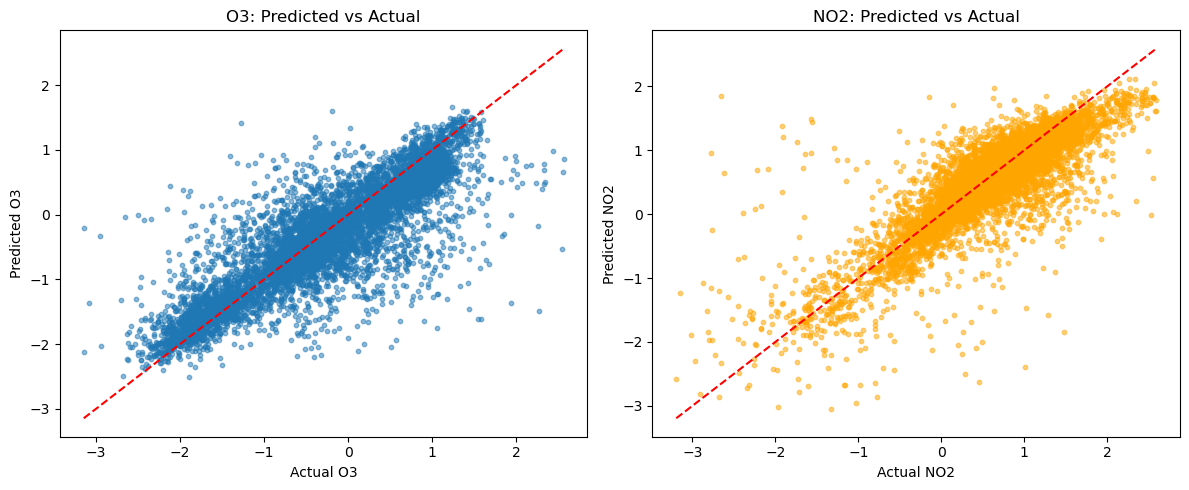

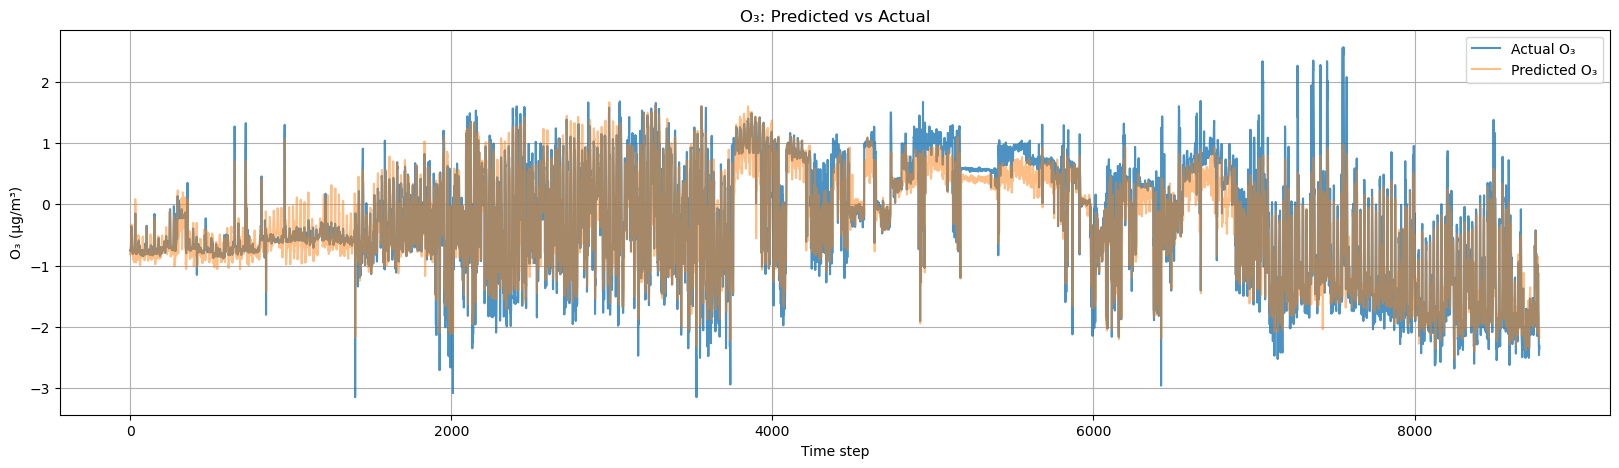

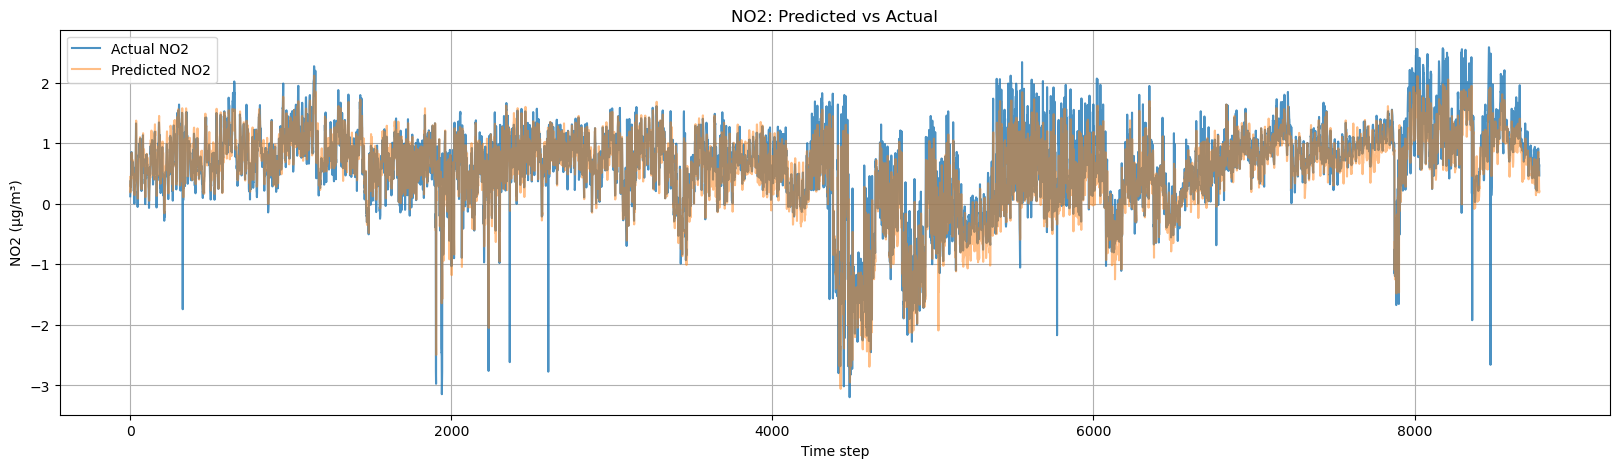

In [757]:
preds_all, labels_all = evaluate_and_plot(model, test_loader, device)
# preds_all, labels_all = evaluate_and_plot(model, dataloader, device)

